In [19]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler


# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [20]:
X_train = pd.read_csv('../../6-X_train_FINAL.csv')
X_test = pd.read_csv('../../6-X_test_FINAL.csv')
X_train=X_train.drop(['VIN'], axis=1)
X_test=X_test.drop(['VIN'], axis=1)

In [21]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [22]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)

In [23]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [24]:

final_columns = ['OBD_MIL_STATUS']
X_train = X_train[final_columns]
X_test = X_test[final_columns]

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report


def cross_validate(cv, balancing_technique, model, categorical_columns = None):
    pipeline = make_pipeline(balancing_technique, model)

    if (categorical_columns != None) :
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = make_pipeline( preprocessor_linear,balancing_technique, model)

    train_acc = []
    test_acc = []
    test_prec = []
    test_recall = []
    test_f1 = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))

        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))

        y_pred = pipeline.predict(X_test)
        precision = precision_score(y_test, y_pred, pos_label=0)
        recall = recall_score(y_test, y_pred, pos_label=0)
        F1Sc = f1_score(y_test, y_pred, pos_label=0)
        test_prec.append(precision)
        test_recall.append(recall)
        test_f1.append(F1Sc)

    print(classification_report(y_val, y_hat_val))
    cm = confusion_matrix(y_val, y_hat_val)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('Test Precision: {}'.format(np.mean(test_prec)))
    print('Test Recall: {}'.format(np.mean(test_recall))) 
    print('Test F1: {}'.format(np.mean(test_f1))) 
    print('\n')


              precision    recall  f1-score   support

           0       1.00      0.46      0.63      1511
           1       0.96      1.00      0.98     22350

    accuracy                           0.97     23861
   macro avg       0.98      0.73      0.80     23861
weighted avg       0.97      0.97      0.96     23861

Training Accuracy: 0.9667502026472397


Validation Accuracy: 0.9667501935494867
Test Precision: 0.9978655282817502
Test Recall: 0.4934036939313985
Test F1: 0.6603107344632768




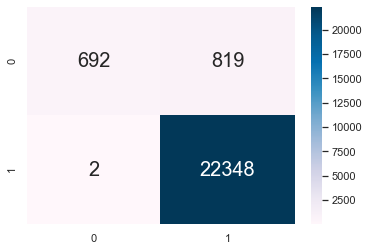

In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier
#Random Forest as model chosen
model = RandomForestClassifier(n_estimators=100, random_state=0)
#Balancing technique: UnderSampling
balancing_technique = RandomUnderSampler(random_state=0)


#Evaluating the model
cross_validate(KFold(), balancing_technique, model)